In [1]:
import json
import numpy as np
import pandas as pd
import requests

In [2]:
def get_json(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        return json.loads(response.content.decode('utf-8'))
    else:
        return None

In [4]:
record_date = '2021-02-17'
covid_url = 'https://covid19-api.org/api/status?date='+record_date
df_covid_worldwide = pd.io.json.json_normalize(get_json(covid_url))

print(df_covid_worldwide.head())

  country          last_update     cases  deaths  recovered
0      US  2021-02-16T23:24:39  27746876  487710          0
1      IN  2021-02-16T23:24:39  10925710  155813   10633025
2      BR  2021-02-16T23:24:39   9921981  240940    8847264
3      GB  2021-02-16T23:24:39   4070326  118421      10974
4      RU  2021-02-16T23:24:39   4053535   79659    3584477


<ipython-input-4-9e950a8e3655>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_covid_worldwide = pd.io.json.json_normalize(get_json(covid_url))


In [10]:
df_covid_worldwide['last_update'] = pd.to_datetime(df_covid_worldwide['last_update'], format='%Y-%m-%d %H:%M:%S')
df_covid_worldwide['last_update'] = df_covid_worldwide['last_update'].apply(lambda x: x.date())

In [11]:
print(df_covid_worldwide.head())

  country last_update     cases  deaths  recovered
0      US  2021-02-16  27746876  487710          0
1      IN  2021-02-16  10925710  155813   10633025
2      BR  2021-02-16   9921981  240940    8847264
3      GB  2021-02-16   4070326  118421      10974
4      RU  2021-02-16   4053535   79659    3584477


In [12]:
countries_url = 'https://covid19-api.org/api/countries'
df_countries = pd.io.json.json_normalize(get_json(countries_url))
df_countries = df_countries.rename(columns={'alpha2': 'country'})[['name','country']]

print(df_countries.head())

          name country
0  Afghanistan      AF
1      Albania      AL
2      Algeria      DZ
3      Andorra      AD
4       Angola      AO


<ipython-input-12-89c7c785ff58>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_countries = pd.io.json.json_normalize(get_json(countries_url))


In [13]:
df_covid_denormalized = pd.merge(df_covid_worldwide, df_countries, on='country')

print(df_covid_denormalized.head())

  country last_update     cases  deaths  recovered  \
0      US  2021-02-16  27746876  487710          0   
1      IN  2021-02-16  10925710  155813   10633025   
2      BR  2021-02-16   9921981  240940    8847264   
3      GB  2021-02-16   4070326  118421      10974   
4      RU  2021-02-16   4053535   79659    3584477   

                                                name  
0                           United States of America  
1                                              India  
2                                             Brazil  
3  United Kingdom of Great Britain and Northern I...  
4                                 Russian Federation  


In [14]:
df_covid_denormalized['fatality_ratio'] = df_covid_denormalized['deaths']/df_covid_denormalized['cases']

In [15]:
df_top_20_fatality_rate = df_covid_denormalized.sort_values(by='fatality_ratio', ascending=False).head(20)

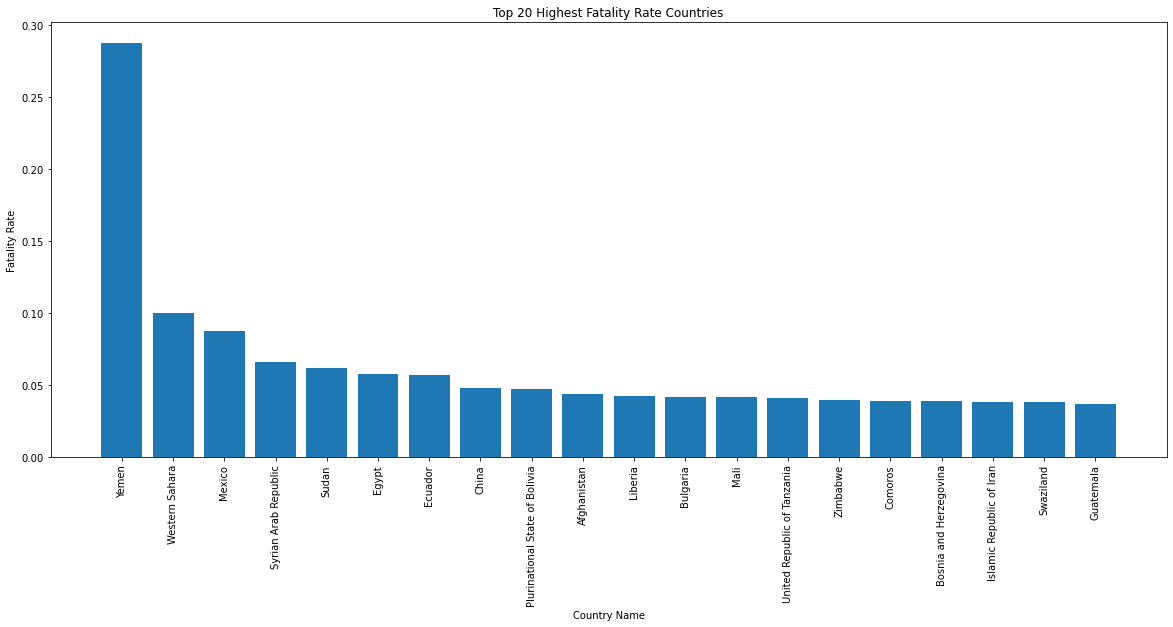

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
x = df_top_20_fatality_rate['name']
y = df_top_20_fatality_rate['fatality_ratio']
plt.bar(x,y)
plt.xlabel('Country Name')
plt.ylabel('Fatality Rate')
plt.title('Top 20 Highest Fatality Rate Countries')
plt.xticks(rotation=90)
plt.show()

In [20]:
countries = ['ID','MY','SG','TH','VN']
i = 0
for country in countries:
    covid_timeline_url = 'https://covid19-api.org/api/timeline/'+country
    df_covid_timeline = pd.io.json.json_normalize(get_json(covid_timeline_url))
    df_covid_timeline['last_update'] = pd.to_datetime(df_covid_timeline['last_update'], format='%Y-%m-%dT%H:%M:%S')
    df_covid_timeline['last_update'] = df_covid_timeline['last_update'].apply(lambda x: x.date())
    if i==0:
        df_covid_timeline_merged = df_covid_timeline
    else:
        df_covid_timeline_merged = df_covid_timeline.append(df_covid_timeline_merged, ignore_index=True)
    i=i+1

print(df_covid_timeline_merged.head())

<ipython-input-20-5d49c6fa2431>:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_covid_timeline = pd.io.json.json_normalize(get_json(covid_timeline_url))


  country last_update  cases  deaths  recovered
0      VN  2021-03-04   2488      35       1920
1      VN  2021-03-03   2482      35       1898
2      VN  2021-03-02   2472      35       1898
3      VN  2021-03-01   2448      35       1876
4      VN  2021-02-28   2448      35       1876


In [21]:
df_covid_timeline_denormalized = pd.merge(df_covid_timeline_merged, df_countries, on='country')

In [22]:
import datetime
df_covid_timeline_denormalized = df_covid_timeline_denormalized[(df_covid_timeline_denormalized['last_update'] >= datetime.date(2020, 3, 1))]

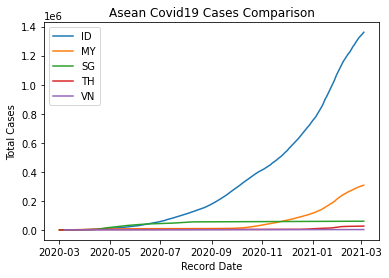

In [24]:
import matplotlib.pyplot as plt
plt.clf()
countries = ['ID','MY','SG','TH','VN']
for country in countries:
    country_data = df_covid_timeline_denormalized['country']==country
    x = df_covid_timeline_denormalized[country_data]['last_update']
    y = df_covid_timeline_denormalized[country_data]['cases']
    plt.plot(x, y, label = country)

plt.legend()
plt.xlabel('Record Date')
plt.ylabel('Total Cases')
plt.title('Asean Covid19 Cases Comparison')
plt.show()